In [2]:
# must be specified to be able to use methods of package
import sys
sys.path.append('../src') 
# import packages
import pandas as pd
from political_ads.Preprocessor import *
from political_ads.helper import *
from political_ads.keyword_filter import *

In [3]:
#Code to read from our full dataset:
preprocess = Preprocessor()
df = preprocess.file_to_df('/home/gustavgyrst/Desktop/Research Project/political-ad-api/data/all_politicians_aggregated.txt')
df.head(3)


,ad_creation_time,ad_creative_body,spend,impressions,delivery_by_region,demographic_distribution,page_id,page_name,bylines,id,spend_lo,spend_hi,impressions_lo,impressions_hi
0,2019-05-20,CONFIRMATION NEEDED: Do you want to save Socia...,149.5,3499.5,"[{'percentage': '0.002362', 'region': 'Mississ...","[{'percentage': '0.000476', 'age': '35-44', 'g...",283932788322459,Pete Aguilar for Congress,Pete Aguilar for Congress,186686335555403,100,199,3000,3999
1,2019-05-20,CALLING ALL DEMOCRATS! Congressman Pete Aguila...,49.5,499.5,"[{'percentage': '0.008929', 'region': 'Marylan...","[{'percentage': '0.008929', 'age': '25-34', 'g...",283932788322459,Pete Aguilar for Congress,Pete Aguilar for Congress,291841175036406,0,99,0,999
2,2019-05-20,CALLING ALL DEMOCRATS! Congressman Pete Aguila...,49.5,499.5,"[{'percentage': '0.009346', 'region': 'New Mex...","[{'percentage': '0.476636', 'age': '65+', 'gen...",283932788322459,Pete Aguilar for Congress,Pete Aguilar for Congress,297843221168257,0,99,0,999


In [33]:
#If representation for climate ads is wanted:
c_filter = Filter()
df_climate = c_filter.get_climate_ads(df)

In [3]:
#General stats
print("There are", len(df[df.impressions_lo == 1000000]), "ads with spending of $1,000,000 or above in the data-set")
print(len(df), "ads in total")
print("There are", len(df.dropna(subset=['demographic_distribution'])), "ads after dropping the nan values in the demographic data")


There are 605 ads with spending of $1,000,000 or above in the data-set
602663 ads in total
There are 463519 ads after dropping the nan values in the demographic data


In [4]:
df['demographic_distribution'][0]

[{'percentage': '0.000476', 'age': '35-44', 'gender': 'unknown'},
 {'percentage': '0.000476', 'age': '18-24', 'gender': 'male'},
 {'percentage': '0.001427', 'age': '25-34', 'gender': 'female'},
 {'percentage': '0.007612', 'age': '65+', 'gender': 'unknown'},
 {'percentage': '0.191246', 'age': '65+', 'gender': 'male'},
 {'percentage': '0.55138', 'age': '65+', 'gender': 'female'},
 {'percentage': '0.139391', 'age': '55-64', 'gender': 'female'},
 {'percentage': '0.065176', 'age': '55-64', 'gender': 'male'},
 {'percentage': '0.000951', 'age': '25-34', 'gender': 'male'},
 {'percentage': '0.016175', 'age': '45-54', 'gender': 'female'},
 {'percentage': '0.004757', 'age': '35-44', 'gender': 'female'},
 {'percentage': '0.011893', 'age': '45-54', 'gender': 'male'},
 {'percentage': '0.000951', 'age': '45-54', 'gender': 'unknown'},
 {'percentage': '0.005233', 'age': '35-44', 'gender': 'male'},
 {'percentage': '0.000951', 'age': '55-64', 'gender': 'unknown'},
 {'percentage': '0.001903', 'age': '18-2

# 1. Demographic Distribution


In [78]:
#lst of failed attempts
lst_of_failed = []
#The list that will be returned
lst  = []

#Get age distribution
def get_age_distribution(row, gender):
    #The list that will be returned
    lst  = []

    #The map of age_dist
    age_dist = {'13-17': 0.0, '18-24': 0.0, '25-34':0.0, '35-44':0.0, '45-54':0.0, '55-64':0.0, '65+':0.0, 'Unknown': 0.0} #important that Unknown is with capital U
    
    for item in row.demographic_distribution:
        
            try:
                if item['gender'] == gender:
                    age = item['age']
                    percentage = float(item['percentage'])
                    age_dist[age] = age_dist.get(age) + percentage
                else: 
                    pass
            except:
                lst_of_failed.append(row[['page_name', 'demographic_distribution']])
                pass  
    
    for key, value in age_dist.items():
        lst.append(value*row['impressions_hi']) # CHANGED SOMETHING HERE NOT TESTED

    return pd.Series(lst)

In [6]:
NaNs = df[df['demographic_distribution'].isna() == True]
print("Amount of NaNs values in the demographic_distribution field:", len(NaNs))
NaNs.head(1)

print(len(NaNs) / len(df))

Amount of NaNs values in the demographic_distribution field: 139144
0.2308819356754936


In [75]:
def create_demographic_df(df:DataFrame):
     demographics = df[['page_name', 'demographic_distribution', 'impressions_hi']].reset_index().drop(columns='index')
     print(len(demographics))
     demographics = demographics.dropna()
     print("Are there nans?:", demographics.isna().any())
     
     #Creating the Columns
     age_dist_lst = ['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'unknown']
     for i in age_dist_lst:
          demographics[i] = 0.0

     return demographics



demographics = create_demographic_df(df_climate)

demographics.head(1)


19176
Are there nans?: page_name                   False
demographic_distribution    False
impressions_hi              False
dtype: bool


,page_name,demographic_distribution,impressions_hi,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown
0,Adam Smith for Congress,"[{'percentage': '0.001887', 'age': '25-34', 'g...",999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
demographics_male = demographics.copy()
demographics_female = demographics.copy()
demographics_unknown = demographics.copy()

In [80]:
#Running for male
demographics_male[['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'unknown']] = demographics.apply(lambda x: get_age_distribution(row=x, gender='male'), axis=1)

In [81]:
#Running for male
demographics_female[['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'unknown']] = demographics.apply(lambda x: get_age_distribution(row = x, gender='female'), axis=1)

In [82]:
demographics_unknown[['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+', 'unknown']] = demographics.apply(lambda x: get_age_distribution(row = x, gender='unknown'), axis=1)

In [83]:
demographics_male['gender'] = 'male'
demographics_female['gender'] = 'female'
demographics_unknown['gender'] = 'unknown'

In [84]:
demographics_male_g = demographics_male.groupby('page_name').sum()
demographics_female_g = demographics_female.groupby('page_name').sum()
demographics_unknown_g = demographics_unknown.groupby('page_name').sum()



demographics_male_g['gender'] = 'male'
demographics_female_g['gender'] = 'female'
demographics_unknown_g['gender'] = 'unknown'


In [85]:
frames = [demographics_female_g,demographics_male_g,demographics_unknown_g]
total = pd.concat(frames)


In [86]:
test = total.groupby('gender').sum()

In [87]:
test.reset_index(inplace=True)
test

,gender,impressions_hi,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown
0,female,124043542,24112.395678,9.969416e+06,1.476539e+07,1.204703e+07,1.017166e+07,1.213529e+07,1.524924e+07,0.000000
1,male,124043542,16043.932623,5.875263e+06,1.168603e+07,8.362113e+06,6.763811e+06,7.064451e+06,8.230505e+06,0.000000
2,unknown,124043542,900.273454,2.381870e+05,3.929163e+05,3.048581e+05,2.101015e+05,2.237900e+05,3.113589e+05,1061.791707


In [88]:
test.set_index('gender', inplace=True)


In [89]:
#dropping some columns
test.drop(columns='impressions_hi', inplace=True)
test.drop(columns='13-17', inplace=True)
test.drop(columns='unknown', inplace=True)

<AxesSubplot:>

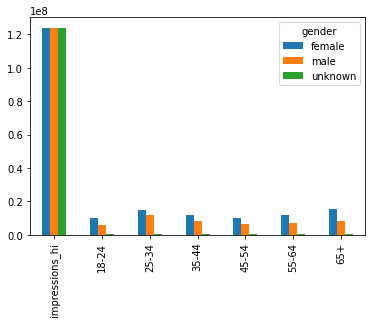

In [90]:
#Overall distribution for all politicians
test.T.plot(kind='bar', style='spring')

# Democrats vs. Republicans

In [91]:
congress = pd.read_csv('/home/gustavgyrst/Desktop/Research Project/political-ad-api/src/data_sets/legislators_fb_info_final.csv')

In [125]:
party = 'Democrat'

party_members = congress[congress["party"] == party]  # get all page id's that match the given party

#Male
demographics_democrats_male = demographics_male[demographics_male.page_name.isin(party_members.page_name)] # get all the ads where page id matches with the party page id's

#Female
demographics_democrats_female = demographics_female[demographics_female.page_name.isin(party_members.page_name)] # get all the ads where page id matches with the party page id's

#Unknown
demographics_democrats_unknown = demographics_unknown[demographics_unknown.page_name.isin(party_members.page_name)]


In [126]:
demographics_democrats_male_g = demographics_democrats_male.groupby('page_name').sum()
demographics_democrats_female_g = demographics_democrats_female.groupby('page_name').sum()
demographics_democrats_unknown_g = demographics_democrats_unknown.groupby('page_name').sum()

demographics_democrats_male_g['gender'] = 'male'
demographics_democrats_female_g['gender'] = 'female'
demographics_democrats_unknown_g['gender'] = 'unknown'


In [127]:
#concatenating the frames
frames_democrats = [demographics_democrats_female_g,demographics_democrats_male_g,demographics_democrats_unknown_g]
total_democrats = pd.concat(frames_democrats)


In [128]:
democrats = total_democrats.groupby('gender').sum()


In [129]:
democrats

,impressions_hi,13-17,18-24,25-34,35-44,45-54,55-64,65+,unknown
gender,,,,,,,,,
female,4941377,2983.987324,654106.296234,565083.336282,357843.166363,325664.583156,481962.946132,664977.276021,0.0
male,4941377,1746.189841,351741.161947,440480.429685,272906.666751,230084.980641,254038.891516,280488.334937,0.0
unknown,4941377,85.617863,13015.127184,13246.204275,8414.465813,5789.084754,6810.252709,9907.587566,0.0


In [130]:
democrats.reset_index(inplace=True)


In [131]:
democrats.set_index('gender', inplace=True)



In [132]:
democrats.drop(columns=['impressions_hi', '13-17', 'unknown'], inplace=True)

<AxesSubplot:>

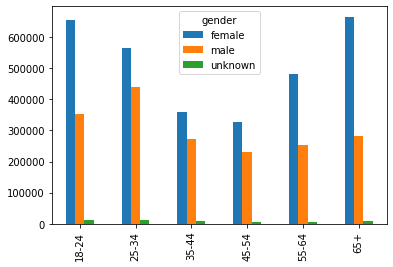

In [135]:
#Overall distribution for all politicians

democrats.T.plot(kind='bar', style='spring')

# Older Code:

In [134]:

demographics_republicans.drop(columns='impressions_hi', inplace=True)

r_view = demographics_republicans.groupby('party').sum()

r_view.iloc[0].plot(kind='bar', title="republicans")


NameError: name 'demographics_republicans' is not defined

In [ ]:
party_r = 'Republican'

party_members = congress[congress["party"] == party_r]  # get all page id's that match the given party

demographics_republicans = demographics[demographics.page_name.isin(party_members.page_name)] # get all the ads where page id matches with the party page id's

demographics_republicans['party'] = 'republican'


/tmp/ipykernel_28043/3402324449.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics_republicans['party'] = 'republican'


# Gender Distribution (Alone)

In [ ]:
#Random sum check
sum = 0
for i in df.demographic_distribution[0]:
    sum += float(i.get('percentage'))
print("The sum of all the percentages given in the dictionary of diff values (yep they don't sum to 100", sum)
#So... they don't even sum up to a hundred



The sum of all the percentages given in the dictionary of diff values (yep they don't sum to 100 0.9999980000000002


In [ ]:
list_of_failed_g = []
count_unknown =0
def get_gender_distribution(row):
    
    #initializing percentages
    percentage_male = 0.0
    percentage_female = 0.0
    percentage_unknown = 0.0

    try:
        for item in row.demographic_distribution:
            if item['gender'] == 'male':
                percentage_male += float(item['percentage'])
            elif item['gender'] == 'female':
                percentage_female += float(item['percentage'])
            elif item['gender'] == 'unknown':
                percentage_unknown += float(item['percentage'])
                count_unknown+=1
    except:
        list_of_failed_g.append(lst)
    
    avg_imp = float(row['avg_impressions'])
    lst_all_genders = [percentage_male, percentage_female, percentage_unknown]
    for i in range(3):
        lst_all_genders[i] = lst_all_genders[i]*avg_imp
    
    #Getting the avg impression to get the weight of the gender distribution
    return pd.Series(lst_all_genders)